# Humpback Whale Identification

In [170]:
import math
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
from IPython.display import clear_output

%matplotlib inline

## Load datasets

#### Unpack images

In [5]:
root_dir = "train"

def unpack_images(root_dir):
    raw_images_df = pd.read_csv('train.csv')
    images = raw_images_df.values.tolist()
    for image, label in images:
        dest_dir = os.path.join(root_dir, label)
        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir)

        os.rename(os.path.join(root_dir, image), os.path.join(dest_dir, image))
        
# unpack_images(root_dir)

#### Prepare transformations

In [126]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((250, 250)),
    transforms.ToTensor()
])

In [127]:
train_dataset = torchvision.datasets.ImageFolder(root=root_dir, 
                                                 transform=transform)

#### Create loaders

In [187]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [181]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

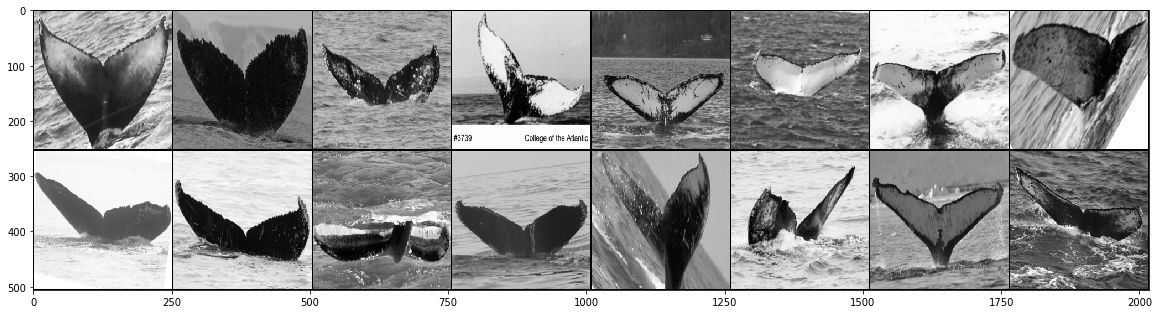

In [160]:
fig, axes = plt.subplots(figsize=(20, 8))

def imshow(x):
#     img = img / 2 + 0.5     # unnormalize
    x = x.numpy()
    x = np.transpose(x, (1, 2, 0))
    plt.imshow(x)
       
imshow(torchvision.utils.make_grid(images))

### Exploring data

In [161]:
df = pd.read_csv('train.csv')
df.groupby('Id').count().sort_values('Image', ascending=False).head()

,Image
Id,
new_whale,9664
w_23a388d,73
w_9b5109b,65
w_9c506f6,62
w_0369a5c,61


In [162]:
df.groupby(df.Id == 'new_whale').count()

,Image,Id
Id,,
False,15697,15697
True,9664,9664


In [163]:
df.Image.unique().shape

(25361,)

In [164]:
tmp_df =  df.groupby('Id').count()
tmp_df[tmp_df.Image >= 2].shape

(2932, 1)

In [165]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert device.type == 'cuda'

print(torch.cuda.get_device_name(0))

GeForce GTX 1060


## Autoencoder approach

### Define autoencoder

In [184]:
class AutoEncoderCNN(nn.Module):
    def __init__(self):
        super(AutoEncoderCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3, padding=1), # b, 32, 67, 200
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2), # b, 32, 33, 100
            nn.Conv2d(32, 16, 3, stride=2, padding=1), # b, 16, 17, 50
            nn.PReLU(),
            nn.MaxPool2d(2, stride=1) # b, 16, 16, 49
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 3, stride=2),
            nn.PReLU(),
            nn.ConvTranspose2d(32, 8, 5, stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 6, stride=2, padding=0, dilation=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)
    
autoencoder = AutoEncoderCNN().to(device)
autoencoder

AutoEncoderCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): PReLU(num_parameters=1)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): PReLU(num_parameters=1)
    (2): ConvTranspose2d(32, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(8, 1, kernel_size=(6, 6), stride=(2, 2))
    (5): Tanh()
  )
)

### Setting loss function and optimizer

In [185]:
lr = 1e-4
weight_decay = 1e-5
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr, weight_decay=weight_decay)

### Train

In [179]:
def prepare_batch(batch):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    return inputs, labels

In [182]:
x = images
print(x.shape)
x = nn.Conv2d(1, 32, 3, stride=3, padding=1)(x)  # b, 32, 67, 200
print(x.shape)
x = nn.PReLU()(x)
x = nn.MaxPool2d(2, stride=2)(x)
print(x.shape)
x = nn.Conv2d(32, 16, 3, stride=2, padding=1)(x)
print(x.shape)
x = nn.PReLU()(x)
x = nn.MaxPool2d(2, stride=1)(x)
print(x.shape)

x = nn.ConvTranspose2d(16, 32, 3, stride=2)(x)
print(x.shape)
x = nn.PReLU()(x)
x = nn.ConvTranspose2d(32, 8, 5, stride=3, padding=1)(x)
print(x.shape)
x = nn.ReLU()(x)
x = nn.ConvTranspose2d(8, 1, 6, stride=2, padding=0, dilation=1)(x)
print(x.shape)
x = nn.Tanh()(x)

torch.Size([16, 1, 250, 250])
torch.Size([16, 32, 84, 84])
torch.Size([16, 32, 42, 42])
torch.Size([16, 16, 21, 21])
torch.Size([16, 16, 20, 20])
torch.Size([16, 32, 41, 41])
torch.Size([16, 8, 123, 123])
torch.Size([16, 1, 250, 250])


In [189]:
n_epochs = 10
examples = len(train_dataset.imgs)
n_batches = math.ceil(examples/batch_size)
loss_history = list()

for epoch in range(n_epochs):
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        inputs, _ = prepare_batch(batch)
        
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_score = loss.item()
        clear_output()
        print(f"[{i}/{n_batches}] loss:{loss_score}")
        
        running_loss += loss_score

    loss_history.append(running_loss)
        
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, n_epochs, running_loss / i))

[1585/1586] loss:0.0019356687553226948
epoch [10/10], loss:0.0058


### Save model

## Define network

In [97]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.n_classes = n_classes
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),
            nn.PReLU(),
            nn.Linear(256, 256),
            nn.PReLU(),
            nn.Linear(256, self.n_classes)
        )
        
    def forward(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output
    
class TripletNet(nn.Module):
    def __init__(self, embedding):
        super(TripletNet, self).__init__()
        self.embedding = embedding
    
    def forward(self, x1, x2, x3):
        output1 = self.embedding(x1)
        output2 = self.embedding(x2)
        output3 = self.embedding(x3)
        return output1, output2, output3
    

cnn = CNN(10)
net = TripletNet(cnn)
net

TripletNet(
  (embedding): CNN(
    (cnn): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): PReLU(num_parameters=1)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (4): PReLU(num_parameters=1)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=256, out_features=10, bias=True)
    )
  )
)

## Train network

Prepare triplet loss function, which take embeddings of an anchor sample, a positive and a negative sample.

In [98]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow().sum(1)
        distance_negative = (anchor - negative).pow().sum(1)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

Set loss function and optimizer

In [99]:
margin = .1
lr = 1e-3
loss_fn = TripletLoss(margin)
optimizer = optim.Adam(net.parameters())

Define train function

In [12]:
def prepare_batch(batch):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    return inputs, labels

def update_model(trainer, batch):
    model.train()
    optimizer.zero_grad()
    inputs, labels = prepare_batch(batch)

## Validate network

## Make predictions 

## Submissions